In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tdwg_lib.split_step_solver import BPMSplitStepSolver
from tdwg_lib.waveguide import Waveguide, add_absorbing_boundary
from tdwg_lib.helpers import smoothen1d, timestring
from tdwg_lib.beam_utils import gaussian_beam
from tdwg_lib.mode_solver import solve_modes
from tdwg_lib.pat import make_pat_func
from tdwg_lib import pnn_utils 
import tdwg_lib.ftutils_torch as ftutils

# Main

In [3]:
NMODES = 3  # Number of waveguide modes to solve for

# Waveguide parameters
LAMBDA0 = 1.55  # Free-space wavelength in μm
K0 = 2*np.pi/LAMBDA0  # Free-space wavenumber in μm⁻¹
NEFF = 1.8  # Effective refractive index of slab mode
D_WG = 5  # Waveguide width in μm

# Transverse (x) axis
LX = 50  # Width of simulation area in μm
NX = 2**9  # Number of grid points in transverse dimension
DX = LX/(NX-1)  # Grid spacing in transverse dimension in μm
X_AXIS = ftutils.ft_t_axis(NX, DX)  # Centered frequency-domain axis

# Propagation (z) axis
DZ = 0.2  # Propagation step size in μm
LZ = 1000  # Total propagation length in μm
NZ = int(np.floor(LZ/DZ))  # Number of propagation steps
Z_AXIS = (torch.arange(NZ)+1)*DZ  # Propagation coordinate starting at DZ

In [4]:
# Define step-index multimode waveguide with smoothed edges and absorbing boundaries
background_delta_n = torch.zeros(NX, dtype=torch.complex64)
background_delta_n[torch.where(X_AXIS.abs() < D_WG/2)] = 0.1  # Step-index profile
background_delta_n = smoothen1d(X_AXIS, background_delta_n, LAMBDA0)  # Smooth edges
background_delta_n = add_absorbing_boundary(X_AXIS, background_delta_n, K0)  # Add PML boundaries

# Waveguide container object stores simulation geometry and parameters
wg = Waveguide(NEFF, X_AXIS, Z_AXIS, background_delta_n)

Text(0.5, 1.0, 'Step-index profile')

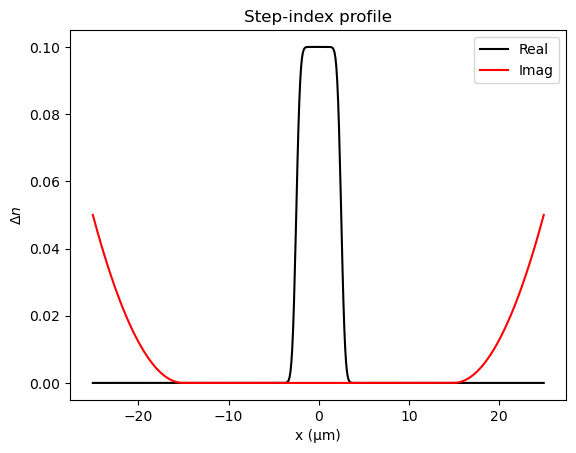

In [5]:
# Plot refractive index profile
plt.plot(X_AXIS, background_delta_n.real, c='k', label='Real')
plt.plot(X_AXIS, background_delta_n.imag, c='r', label='Imag')
plt.xlabel('x (μm)')
plt.ylabel(r'$\Delta n$')
plt.legend()
plt.title('Step-index profile')

In [6]:
# Solve for first N TE modes and their propagation constants (betas) using eigenmode solver
betas, modes = solve_modes(wg.x_axis.numpy(), NEFF, K0, background_delta_n.numpy(), NMODES, fresnel=True)

# Convert to PyTorch tensors
betas = torch.from_numpy(betas)
modes = torch.from_numpy(modes)

Text(0.5, 1.0, 'Waveguide modes')

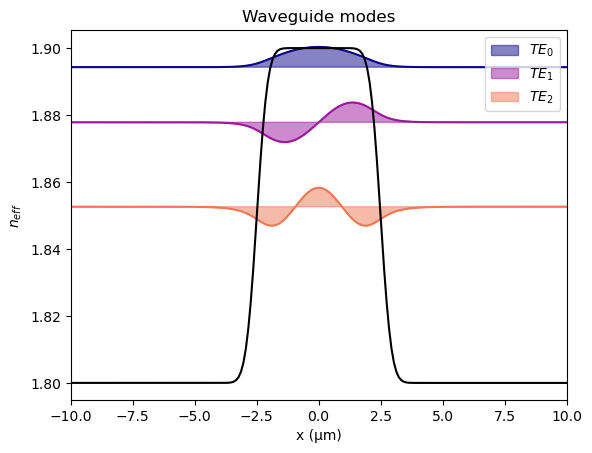

In [7]:
import matplotlib.cm as cm

for ind_mode, (mode, beta) in enumerate(zip(modes, betas)):
    # Plot mode profile offset by its effective index
    plt.fill_between(X_AXIS, beta/K0, mode/100 + beta/K0, label=f'$TE_{ind_mode}$', color=cm.plasma(ind_mode/NMODES), alpha=0.5)
    plt.plot(X_AXIS, mode/100 + beta/K0, color=cm.plasma(ind_mode/NMODES))

# Plot background index profile
plt.plot(X_AXIS, NEFF + background_delta_n.real, c='k')

plt.legend(loc='upper right')
plt.xlim(-10, 10)
plt.xlabel('x (μm)')
plt.ylabel(r'$n_{eff}$')
plt.title('Waveguide modes')

In [8]:
# Initialize beam propagation method solver
bpmsolver = BPMSplitStepSolver(X_AXIS, Z_AXIS, NEFF)

## Unperturbed propagation

In [16]:
# Create 2D refractive index distribution: 
# repeat background profile along z to emulate pre-etched waveguide
background_delta_n_2d = wg.background_delta_n.repeat(wg.Nz, 1)

# Simulate mode propagation through unperturbed waveguide
E_out = bpmsolver.run_simulation(modes, background_delta_n_2d, monitor=True)

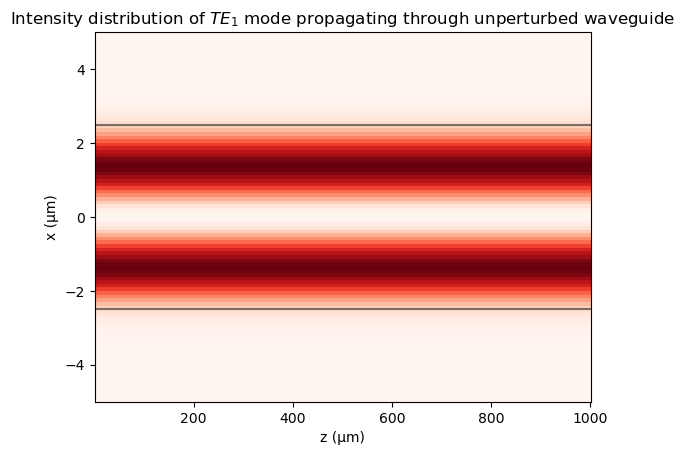

In [17]:
IND_MODE = 1  # Mode index to plot

# Plot intensity distribution: |E|² for selected mode
plt.pcolormesh(wg.z_axis, wg.x_axis, bpmsolver.Emat_x[:, IND_MODE].abs().square().T, cmap='Reds')
plt.xlabel('z (μm)')
plt.ylabel('x (μm)')
plt.title(f'Intensity distribution of $TE_{IND_MODE}$ mode propagating through unperturbed waveguide')
plt.ylim(-D_WG, D_WG)
plt.axhline(D_WG/2, color='k', alpha=0.5)  # Mark waveguide boundaries
plt.axhline(-D_WG/2, color='k', alpha=0.5)

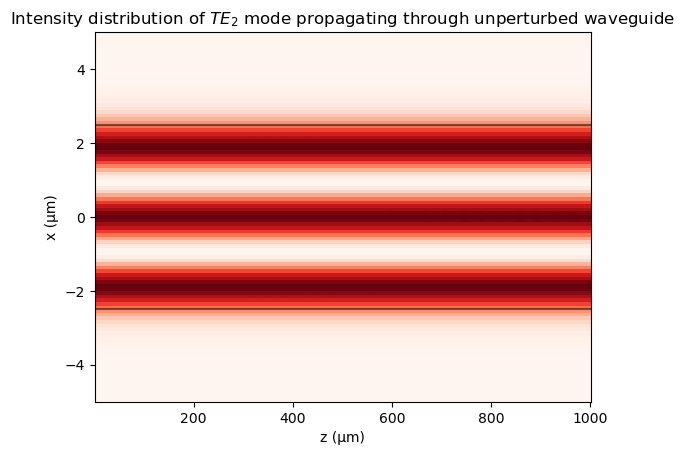

In [18]:
IND_MODE = 2  # Mode index to plot

# Plot intensity distribution: |E|² for selected mode
plt.pcolormesh(wg.z_axis, wg.x_axis, bpmsolver.Emat_x[:, IND_MODE].abs().square().T, cmap='Reds')
plt.xlabel('z (μm)')
plt.ylabel('x (μm)')
plt.title(f'Intensity distribution of $TE_{IND_MODE}$ mode propagating through unperturbed waveguide')
plt.ylim(-D_WG, D_WG)
plt.axhline(D_WG/2, color='k', alpha=0.5)  # Mark waveguide boundaries
plt.axhline(-D_WG/2, color='k', alpha=0.5)

## Coupling modes

In [11]:
# Design refractive index grating for mode conversion between TE1 and TE2
IND1, IND2 = 1, 2  # Mode indices to couple

# Transverse profile: product of mode profiles, normalized by overlap integral
dn_transverse_profile = modes[IND1] * modes[IND2] / (modes[IND1].abs().square() * modes[IND2].abs().square() * DX).sum()

# Propagation profile: phase-matching grating with period Λ = 2π/(β₂ - β₁)
dn_propagation_profile = torch.exp(1j * Z_AXIS * (betas[IND2] - betas[IND1]))

# Combine transverse and propagation profiles, scale amplitude for π coupling over length LZ
dn = (dn_transverse_profile[None, :] * dn_propagation_profile[:, None]).real * np.pi / (K0 * LZ)

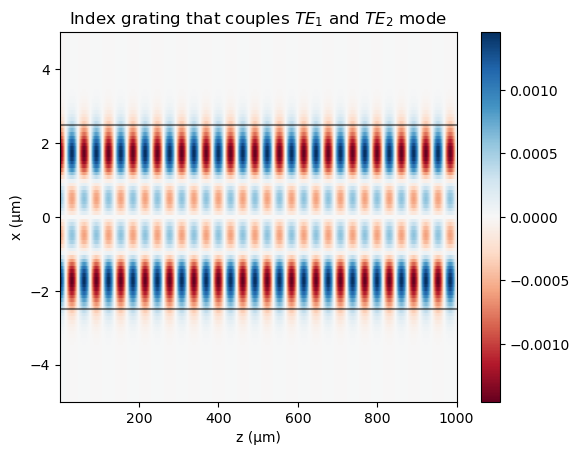

In [12]:
# Plot index grating
plt.pcolormesh(wg.z_axis, wg.x_axis, dn.T, cmap='RdBu', vmin=-dn.abs().max(), vmax=dn.abs().max())
plt.xlabel('z (μm)')
plt.ylabel('x (μm)')
plt.title(f'Index grating that couples $TE_{IND1}$ and $TE_{IND2}$ mode')
plt.ylim(-D_WG, D_WG)
plt.axhline(D_WG/2, color='k', alpha=0.5)  # Mark waveguide boundaries
plt.axhline(-D_WG/2, color='k', alpha=0.5)
plt.colorbar()

In [13]:
# Create 2D refractive index: background + coupling grating
background_delta_n_2d = wg.background_delta_n.repeat(wg.Nz, 1)

# Simulate mode propagation through perturbed waveguide with grating
E_out = bpmsolver.run_simulation(modes, background_delta_n_2d + dn, monitor=True)

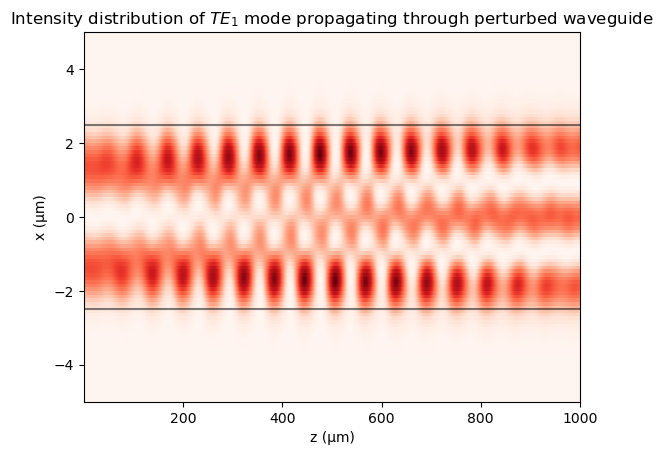

In [14]:
IND_MODE = 1  # Mode index to plot

# Plot intensity distribution showing mode conversion
plt.pcolormesh(wg.z_axis, wg.x_axis, bpmsolver.Emat_x[:, IND_MODE].abs().square().T, cmap='Reds')
plt.xlabel('z (μm)')
plt.ylabel('x (μm)')
plt.title(f'Intensity distribution of $TE_{IND_MODE}$ mode propagating through perturbed waveguide')
plt.ylim(-D_WG, D_WG)
plt.axhline(D_WG/2, color='k', alpha=0.5)  # Mark waveguide boundaries
plt.axhline(-D_WG/2, color='k', alpha=0.5)

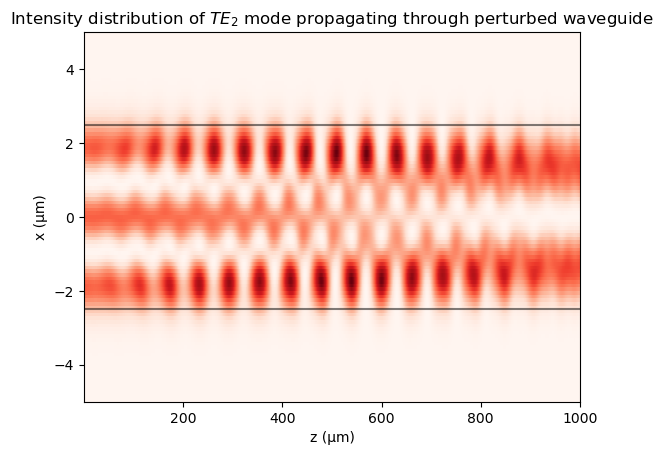

In [15]:
IND_MODE = 2  # Mode index to plot

# Plot intensity distribution showing mode conversion
plt.pcolormesh(wg.z_axis, wg.x_axis, bpmsolver.Emat_x[:, IND_MODE].abs().square().T, cmap='Reds')
plt.xlabel('z (μm)')
plt.ylabel('x (μm)')
plt.title(f'Intensity distribution of $TE_{IND_MODE}$ mode propagating through perturbed waveguide')
plt.ylim(-D_WG, D_WG)
plt.axhline(D_WG/2, color='k', alpha=0.5)  # Mark waveguide boundaries
plt.axhline(-D_WG/2, color='k', alpha=0.5)